# Suplementary Figures

H. Sanchez & F. Palmero @ Nynke Dekker Lab \
2022/11/05

In [46]:
# Imports
import os
import yaml
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.stats.proportion
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings("ignore")

## Figure 4.1

In [3]:
# Directory for figures data
data_dir = r'figure_data/Suplementary Figures/Figure 4.1'

# Directory for raw data
data_path = os.path.join(data_dir, "scans_example.csv")

In [4]:
# DNA information
dna_length = 10.439         # kbp
origin = 6.896              # kbp location of the origin of replication
NPS1 = 6.750                # kbp location of the first nucleosome position sequence
NPS2 = 7.04                 # kbp location of the second nucleosome position sequence
locs_from_center = [ dna_length/2 - origin]  # Locations from center in kbp.

# Location bins; origin should be in third bin
binwidth = (origin - dna_length/2) / 2.5

In [5]:
df_scans = pd.read_csv(data_path)
df_scans.head()

Unnamed: 0.1  Unnamed: 0  frame  intensity  frame_subindex  track_id  \
0           116         116      0       79.0               0         0   
1           117         117      1       61.0               0         0   
2           118         118      2       50.0               0         0   
3           119         119      4       47.0               0         0   
4           120         120      5       43.0               0         0   

   scan_id  dna_start_pixel  dna_end_pixel  n_scans  ...  col_dist  trace_id  \
0        3        14.917998      76.781473       79  ...       NaN         0   
1        3        14.917998      76.781473       79  ...       NaN         0   
2        3        14.917998      76.781473       79  ...       NaN         0   
3        3        14.917998      76.781473       79  ...       NaN         0   
4        3        14.917998      76.781473       79  ...       NaN         0   

   corrected_intensity  dna_length_kbp  laser_colors time_s     x_kbp  \
0                 79.0          10.439            rb    0.0  6.972088   
1                 61.0          10.439            rb    0.6  6.993481   
2                 50.0          10.439            rb    1.2  6.685107   
3                 47.0          10.439            rb    2.4  6.802189   
4                 43.0          10.439            rb    3.0  6.897848   

   x_micron  step_count  lifetime  
0  1.999787         1.0      10.0  
1  2.005923         1.0      10.0  
2  1.917472         1.0      10.0  
3  1.951055         1.0      10.0  
4  1.978493         1.0      10.0  

[5 rows x 28 columns]

In [6]:
def plot_location_histogram(NN, fig, ax, bandw, cut_v, lw, color_s, binwidth,
                            data, color='gray', edgecolor='k', ylim=0.3, filename=None, vlines=[]):
    """Generate location histogram figure."""

    # Config axis
    ax2 = ax.twinx()
    ax.set_ylim((0, 1.1))
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1])

    ax2.set_ylim(0, ax.get_ylim()[1] / binwidth)
    ax2.set_yticks([0.0, 0.5, 1, 1.5])
    ax2.axvline(x=locs_from_center, color='k', linestyle='--', zorder=100)

    ax2.set_ylabel(f'PDF (1/kbp)', color='#de59d7', rotation=270, labelpad=22,
                       path_effects=[pe.withStroke(linewidth=2, foreground='black', capstyle="round")])

    ax.set_ylabel('Fraction')
    ax.set_xlabel("kbp from DNA center")

    plt.xlim((0, binwidth*len(data['bins'])))
    plt.xticks([0, 1, 2, 3, 4, 5])
    plt.xlabel('kbp from DNA center')

    # Plot histogram.
    ax.bar(data['bins'], data['values'], align='center', width=data['bin_width'], color=color, edgecolor=edgecolor)

    plt.annotate("$N_{scans}$ = " + str(NN), xy=(0.99, 0.98),
                 xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')
    plt.annotate("$N_{foci}$ = " + str(len(data['locs_all'])), xy=(0.99, 0.85),
                 xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')

    for x in vlines:
        plt.axvline(x, linestyle='dashed', color='k')

    # Include density plot
    sns.kdeplot(data['locs_all'], bw_method=bandw, cut=cut_v, linewidth= 2,
                    color='#de59d7', path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()],
                     ax=ax2, zorder=99);

    # Cleanup.
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)
    return fig

def plot_stoichiometry(NN, data, fig, ax, colors=None, edgecolor=None, filename=None, method='wilson',
                       significance=0.3173):
    """Generate stoichiometry figure."""

    # Config axis
    if not data['norm_per_scan']:
        plt.ylabel('Fraction')
    else:
        plt.ylabel('count per scan')

    # Plot bar
    if colors is None:
        ax.bar(data['x'], data['freqs'], align='center', width=0.8, color='gray')
    else:
        ax.bar(data['x'], data['freqs'], align='center', width=0.8, color=colors, edgecolor=edgecolor)

    # Cleanup.
    ax.xaxis.set_major_locator(plt.FixedLocator(data['x']))
    ax.xaxis.set_major_formatter(plt.FixedFormatter(data['names']))
    plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    plt.ylim(0, 0.9)
    plt.annotate("$N_{foci}$ = " + str(data['n_traces']), xy=(0.99, 0.98),
                 xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')

    # Add standard error of the proportion
    n_obs = data['n_traces']
    errs = []
    for b, c in zip(data['x'], data['freqs']):
        if c == 0:
            err = [0, 0]
        else:
            err = list(statsmodels.stats.proportion.proportion_confint(c * n_obs, n_obs,
                                                                       alpha=significance, method=method))
            err[0] = c - err[0]
            err[1] = err[1] - c
        errs.append(err)
    errs = np.array(errs).swapaxes(0, 1)

    plt.errorbar(data['x'], data['freqs'], errs, fmt=' ', color='k', capsize=5, elinewidth=1, markeredgewidth=1)

    fig.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)

    return fig, ax

def plot_lifetime(data,  color, ax):
    """Plot the lifetime data generated with get_lifetime()."""

    ax.plot(data['xvals'], data['yvals'], 'o', color='k')
    ax.plot(data['xvals'], data['yfit'], color=color, linewidth= 5)
    ax.annotate("$N_{dyes}$ = " + str(data['count']), xy=(0.99, 0.98),
                xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')
    ax.annotate("τ= %.2f " % data['mean_lifetime'] + data['t_unit']
                + " ± %.2f " % data['std'] + data['t_unit'], xy=(0.99, 0.85),
                xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')

    return fig, ax

In [7]:
def get_visible_h2a(p_h2a, p_l, p_occ):
    """Calculate number of visible h2a from association probability and labeling efficiency."""
    
    # Calculate chances of site occupation.
    p_occ0 = (1 - p_occ) ** 2
    p_occ1 = 2 * p_occ * (1 - p_occ)
    p_occ2 = p_occ ** 2
    
    # Calculate chances of tetrasome, hexasome, full nucleosome, if site is occupied.
    p_tet = (1 - p_h2a) ** 2
    p_hex = 2 * p_h2a * (1 - p_h2a)
    p_nuc = p_h2a ** 2
    
    # Calculate the probability distribution for the number of h2a (n) at the double NPS sites.
    # Not necessary to calculate p_n0
    p_n1 = p_occ1 * p_hex + \
           p_occ2 * 2 * p_tet * p_hex
    p_n2 = p_occ1 * p_nuc + \
           p_occ2 * (p_hex ** 2 + 2 * p_tet * p_nuc)
    p_n3 = p_occ2 * 2 * p_hex * p_nuc
    p_n4 = p_occ2 * p_nuc ** 2
    
    # Calculate the probability distribution for the number of visible  h2a (m).
    # Not necessary to calculate p_m0
    p_m1 = p_n1 * p_l + \
           p_n2 * 2 * p_l * (1 - p_l) + \
           p_n3 * 3 * p_l * (1 - p_l) ** 2 + \
           p_n4 * 4 * p_l * (1 - p_l) ** 3
    p_m2 = p_n2 * p_l ** 2 + \
           p_n3 * 3 * p_l ** 2 * (1 - p_l) + \
           p_n4 * 6 * p_l ** 2 * (1 - p_l) ** 2
    p_m3 = p_n3 * p_l ** 3 + \
           p_n4 * 4 * p_l ** 3 * (1 - p_l)
    p_m4 = p_n4 * p_l ** 4
    
    # Return normalized visible probabilities.
    p_array_visible = np.array([p_m1, p_m2, p_m3, p_m4])
    return p_array_visible / np.sum(p_array_visible)

In [8]:
# Config style
font = {'family':'arial', 'size'   : 20}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42

# Set the number of molecules #TODO: Check
NN = len(df_scans['file_name'].unique())

# Generate figure
fig = plt.figure(constrained_layout=True,figsize=(10, 4))
gs = GridSpec(1, 2, figure=fig, width_ratios=[1.5,1])

###############################
# Plot localization histogram #
###############################

# Create axis
ax1 = fig.add_subplot(gs[0])

# Read data to plot
with open(os.path.join(data_dir, "datar00bl.yaml"), "r") as file:
       datar00bl = yaml.safe_load(file)

# Set plot parameters
bandw= binwidth/2
cut_v= 6
lw= 2
color_s= 'k'

# Plot histogram
plot_location_histogram(NN, fig, ax1, bandw, cut_v, lw, color_s, binwidth, datar00bl, '#9999ff' , edgecolor='k',
        ylim=0.8, vlines=[abs (dna_length/2 - NPS1), 
                        abs (dna_length/2 - NPS2)])

##################################
# Plot stoichiometries at origin #
##################################

# Create axis
ax3 = fig.add_subplot(gs[1])

# Read data to plot
with open(os.path.join(data_dir, "datab0ori.yaml"), "r") as file:
       datab0ori = yaml.safe_load(file)
plot_stoichiometry(NN, datab0ori, fig, ax3, '#9999ff', edgecolor='k')

# Save data to do statisctics with stoichiometry
# raw_countsrbST = np.array(datab0ori['total_spots'], dtype='int')
# np.save(os.path.join(data_dir, r'analysis_results/03stoichiometry_orirST5.npy'), raw_countsrbST)


#################
# Probabilities #
#################

p_label = 0.81                            # Labeling efficiency.
p_occupancy = 0.7                         # Single site occupation probability.(from n_jumps)
p_data = np.array(datab0ori['freqs'])     # Real data

p_data = p_data / np.sum(p_data)          # Make sure p_data is normalized.

def mse_h2a_scalar(p_h2a, p_l=p_label, p_occ=p_occupancy, p_experiment=p_data):
    """Calculate the MSE with scalar input."""

    p_predict = get_visible_h2a(p_h2a, p_l, p_occ)
    return np.mean((p_predict - p_experiment)**2)

def mse_h2a_tuple(p_tuple, p_l=p_label, p_experiment=p_data):
    """Calculate the MSE with p_h2a and p_occ as a tuple/array input."""
    p_h2a, p_occ = p_tuple
    p_predict = get_visible_h2a(p_h2a, p_l, p_occ)
    return np.mean((p_predict - p_experiment)**2)

# 1. Varying only p_h2a.
res = scipy.optimize.minimize_scalar(mse_h2a_scalar)
print('Optimal solution, only varying p_h2a: p_h2a =', res.x)
print('Resulting in stoichiometries', get_visible_h2a(res.x, p_label, p_occupancy))
print('MSE:', res.fun, '\n')

# Prepare for parameter declarations.
overview_model = {'data_dir': data_dir,
                  'Optimal solution, only varying p_h2a: p_h2a =' : res.x,
                  'MSE_only varying p_h2a' : res.fun}

# 2. Varying both probabilities.
res = scipy.optimize.minimize(mse_h2a_tuple, x0=[res.x, p_occupancy], bounds=[(0., 1.), (0., 1.)])
print('Optimal solution, varying p_h2a and p_occupancy: [p_h2a, p_occupancy] =', res.x)
print('Resulting in stoichiometries', get_visible_h2a(res.x[0], p_label, res.x[1]))
print('MSE:', res.fun)

overview_model ['Optimal solution, varying p_h2a and p_occupancy: p_h2a ='] = res.x
overview_model ['MSE_ varying p_h2a and p_occupancy'] = res.fun

# Save overview model
with open(os.path.join(data_dir, 'overview_model.yaml'), 'w') as file:
           documents = yaml.dump(overview_model, file)                                    
overview_model

############
# Plot bar #
############

# Compute height
height = get_visible_h2a(res.x[0], p_label, res.x[1])

# Plot bar
ax3.bar(datab0ori['x'], height, alpha=0.5,  fill=False, edgecolor='black', hatch="/")
for xval, fval in zip(datab0ori['x'], height):
    ax3.text(xval, 0.02, "%.2f" % fval, horizontalalignment='center', color = 'white')

ax3.set_xlabel("#H2A")
ax3.set_xticklabels(('1','2','3','4'))
ax3.set_yticklabels(('0.0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8'))

plt.show()

Optimal solution, only varying p_h2a: p_h2a = 0.9215951870501146
Resulting in stoichiometries [0.2074954  0.38517555 0.23461458 0.17271447]
MSE: 0.0019643915817501873 

Optimal solution, varying p_h2a and p_occupancy: [p_h2a, p_occupancy] = [0.72679569 0.97578798]
Resulting in stoichiometries [0.18553121 0.36436865 0.33148355 0.11861658]
MSE: 0.000510085147855949


In [9]:
#################
# MSE landscape #
#################

# Config style
font = {'family':'arial', 'size'   : 20}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42

# Set parameters
n_pixels = 256
p_map = np.zeros((n_pixels, n_pixels))
p_min = np.zeros((n_pixels, n_pixels, 4))

# Compute p_h2a and p_occupancy
for x in range(n_pixels):
    for y in range(n_pixels):
        p_h2a = x / n_pixels
        p_o = y / n_pixels
        z = mse_h2a_scalar(p_h2a, p_label, p_o)
        p_map[x, y] = z

# Set scale
mse_min = np.amin(p_map[~np.isnan(p_map)].flatten())
x_min = np.nan
y_min = np.nan
for x in range(n_pixels):
    for y in range(n_pixels):
        if p_map[x, y] < mse_min * 1.001:
            p_min[x, y] = (1, 0, 0, 1)
            if not np.isnan(x_min):
                print('Warning: x_min, y_min already set...')
                print(f'Changed it from {x_min}, {y_min} to {x}, {y}')
            x_min = x
            y_min = y
        else:
            p_min[x, y] = (0, 0, 0, 0)

# Generate figure
plt.figure()

# Customize figure
plt.xlabel('$p_{occupancy}$')
plt.ylabel('$p_{h2a}$')
plt.title('minimum MSE\n$p_{label}$ = %.2f' % p_label)
plt.yticks(np.arange(0, n_pixels+1, n_pixels/10), ('0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8',' ', '1' ))
plt.xticks(np.arange(0, n_pixels+1, n_pixels/10), ('0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8',' ', '1' ))

# Plot landscape
plt.imshow(p_map, origin='lower', cmap='BuPu_r', vmin=0, vmax=0.02)
cbar = plt.colorbar(label='MSE', ticks=[0., 0.005, 0.01, 0.015, 0.02])
cbar.ax.set_yticklabels(['0.00', '0.005', '0.010', '0.015', '>0.020'])
plt.scatter([y_min], [x_min], c='r', s=5)

plt.show()
plt.close()

## Figure 1.4

In [10]:
# Directory for figures data
data_dir = r'figure_data/Suplementary Figures/Figure 1.4'

# Directory for raw data
data_path = os.path.join(data_dir, "scans_example.csv")

In [11]:
def make_plot(data_dir, sample):
    # Config style
    font = {'family':'arial', 'size'   : 20}
    plt.rc('font', **font)
    plt.rcParams['pdf.fonttype'] = 42

    # Set the number of molecules
    df_scans = pd.read_csv(os.path.join(data_dir, sample, 'scans_example.csv'))
    NN = len(df_scans['file_name'].unique())

    # Generate figure
    fig = plt.figure(constrained_layout=True,figsize=(10, 4))
    gs = GridSpec(1, 2, figure=fig, width_ratios=[1.5,1])

    ###############################
    # Plot localization histogram #
    ###############################

    # Create axis
    ax1 = fig.add_subplot(gs[0])

    # Read data to plot
    with open(os.path.join(data_dir, sample, "datar00bl.yaml"), "r") as file:
        datar00bl = yaml.safe_load(file)

    # Set plot parameters
    bandw= binwidth/2
    cut_v= 6
    lw= 2
    color_s= 'k'

    # Plot histogram
    plot_location_histogram(NN, fig, ax1, bandw, cut_v, lw, color_s, binwidth, datar00bl, '#9999ff' , edgecolor='k',
            ylim=0.8, vlines=[abs (dna_length/2 - NPS1), 
                            abs (dna_length/2 - NPS2)])

    ##################################
    # Plot stoichiometries at origin #
    ##################################

    # Create axis
    ax3 = fig.add_subplot(gs[1])

    # Read data to plot
    with open(os.path.join(data_dir, sample, "datab0ori.yaml"), "r") as file:
        datab0ori = yaml.safe_load(file)
    plot_stoichiometry(NN, datab0ori, fig, ax3, '#9999ff', edgecolor='k')

    # Save data to do statisctics with stoichiometry
    # raw_countsrbST = np.array(datab0ori['total_spots'], dtype='int')
    # np.save(os.path.join(data_dir, r'analysis_results/03stoichiometry_orirST5.npy'), raw_countsrbST)

    #################
    # Probabilities #
    #################

    p_label = 0.81                            # Labeling efficiency.
    p_occupancy = 0.7                         # Single site occupation probability.(from n_jumps)
    p_data = np.array(datab0ori['freqs'])     # Real data

    p_data = p_data / np.sum(p_data)          # Make sure p_data is normalized.

    def mse_h2a_scalar(p_h2a, p_l=p_label, p_occ=p_occupancy, p_experiment=p_data):
        """Calculate the MSE with scalar input."""

        p_predict = get_visible_h2a(p_h2a, p_l, p_occ)
        return np.mean((p_predict - p_experiment)**2)

    def mse_h2a_tuple(p_tuple, p_l=p_label, p_experiment=p_data):
        """Calculate the MSE with p_h2a and p_occ as a tuple/array input."""
        p_h2a, p_occ = p_tuple
        p_predict = get_visible_h2a(p_h2a, p_l, p_occ)
        return np.mean((p_predict - p_experiment)**2)

    # 1. Varying only p_h2a.
    res = scipy.optimize.minimize_scalar(mse_h2a_scalar)
    print('Optimal solution, only varying p_h2a: p_h2a =', res.x)
    print('Resulting in stoichiometries', get_visible_h2a(res.x, p_label, p_occupancy))
    print('MSE:', res.fun, '\n')

    # Prepare for parameter declarations.
    overview_model = {'data_dir': data_dir,
                    'Optimal solution, only varying p_h2a: p_h2a =' : res.x,
                    'MSE_only varying p_h2a' : res.fun}

    # 2. Varying both probabilities.
    res = scipy.optimize.minimize(mse_h2a_tuple, x0=[res.x, p_occupancy], bounds=[(0., 1.), (0., 1.)])
    print('Optimal solution, varying p_h2a and p_occupancy: [p_h2a, p_occupancy] =', res.x)
    print('Resulting in stoichiometries', get_visible_h2a(res.x[0], p_label, res.x[1]))
    print('MSE:', res.fun)

    overview_model ['Optimal solution, varying p_h2a and p_occupancy: p_h2a ='] = res.x
    overview_model ['MSE_ varying p_h2a and p_occupancy'] = res.fun

    # Save overview model
    with open(os.path.join(data_dir, sample, 'overview_model.yaml'), 'w') as file:
            documents = yaml.dump(overview_model, file)                                    
    overview_model

    ############
    # Plot bar #
    ############

    # Compute height
    height = get_visible_h2a(res.x[0], p_label, res.x[1])

    # Plot bar
    ax3.bar(datab0ori['x'], height, alpha=0.5,  fill=False, edgecolor='black', hatch="/")
    for xval, fval in zip(datab0ori['x'], height):
        ax3.text(xval, 0.02, "%.2f" % fval, horizontalalignment='center', color = 'white')

    ax3.set_xlabel("#H2A")
    ax3.set_xticklabels(('1','2','3','4'))
    ax3.set_yticklabels(('0.0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8'))

    plt.show()

    #################
    # MSE landscape #
    #################

    # Config style
    font = {'family':'arial', 'size'   : 20}
    plt.rc('font', **font)
    plt.rcParams['pdf.fonttype'] = 42

    # Set parameters
    n_pixels = 256
    p_map = np.zeros((n_pixels, n_pixels))
    p_min = np.zeros((n_pixels, n_pixels, 4))

    # Compute p_h2a and p_occupancy
    for x in range(n_pixels):
        for y in range(n_pixels):
            p_h2a = x / n_pixels
            p_o = y / n_pixels
            z = mse_h2a_scalar(p_h2a, p_label, p_o)
            p_map[x, y] = z

    # Set scale
    mse_min = np.amin(p_map[~np.isnan(p_map)].flatten())
    x_min = np.nan
    y_min = np.nan
    for x in range(n_pixels):
        for y in range(n_pixels):
            if p_map[x, y] < mse_min * 1.001:
                p_min[x, y] = (1, 0, 0, 1)
                if not np.isnan(x_min):
                    print('Warning: x_min, y_min already set...')
                    print(f'Changed it from {x_min}, {y_min} to {x}, {y}')
                x_min = x
                y_min = y
            else:
                p_min[x, y] = (0, 0, 0, 0)

    # Generate figure
    plt.figure()

    # Customize figure
    plt.xlabel('$p_{occupancy}$')
    plt.ylabel('$p_{h2a}$')
    plt.title('minimum MSE\n$p_{label}$ = %.2f' % p_label)
    plt.yticks(np.arange(0, n_pixels+1, n_pixels/10), ('0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8',' ', '1' ))
    plt.xticks(np.arange(0, n_pixels+1, n_pixels/10), ('0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8',' ', '1' ))

    # Plot landscape
    plt.imshow(p_map, origin='lower', cmap='BuPu_r', vmin=0, vmax=0.02)
    cbar = plt.colorbar(label='MSE', ticks=[0., 0.005, 0.01, 0.015, 0.02])
    cbar.ax.set_yticklabels(['0.00', '0.005', '0.010', '0.015', '>0.020'])
    plt.scatter([y_min], [x_min], c='r', s=5)

    plt.show()
    plt.close()

Optimal solution, only varying p_h2a: p_h2a = 0.9146589081325405
Resulting in stoichiometries [0.21206372 0.38528533 0.23481194 0.16783901]
MSE: 0.008435403527808149 

Optimal solution, varying p_h2a and p_occupancy: [p_h2a, p_occupancy] = [0.72810059 1.        ]
Resulting in stoichiometries [0.16761928 0.3614558  0.34642076 0.12450416]
MSE: 0.0017034971064841641


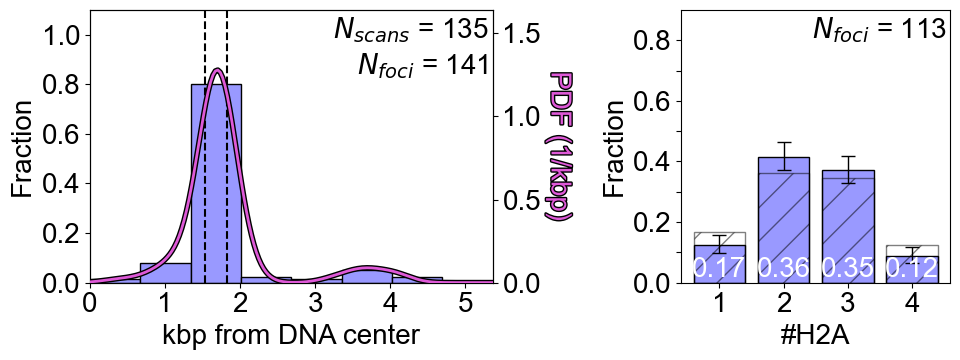

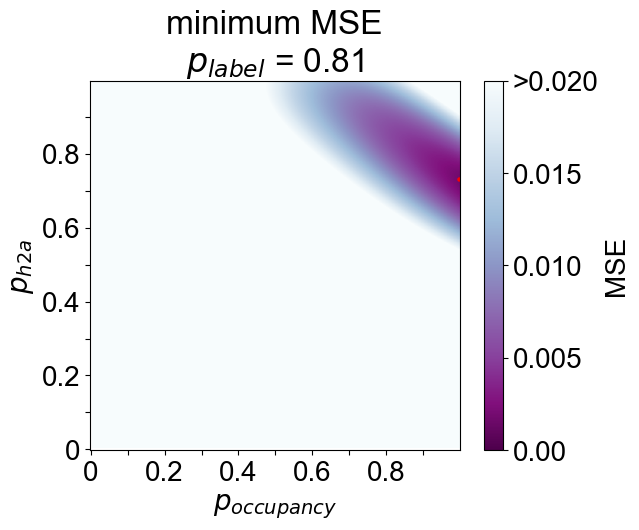

Optimal solution, only varying p_h2a: p_h2a = 0.9350346837692629
Resulting in stoichiometries [0.19868814 0.38501888 0.23381862 0.18247436]
MSE: 0.006227475682069266 

Optimal solution, varying p_h2a and p_occupancy: [p_h2a, p_occupancy] = [0.82425318 0.92695799]
Resulting in stoichiometries [0.14892131 0.32418199 0.35074819 0.17614851]
MSE: 0.0003251865064788848


Optimal solution, only varying p_h2a: p_h2a = 0.9740527538688896
Resulting in stoichiometries [0.17339834 0.38518451 0.22815355 0.2132636 ]
MSE: 0.009839094793073265 

Optimal solution, varying p_h2a and p_occupancy: [p_h2a, p_occupancy] = [0.90389736 0.90887534]
Resulting in stoichiometries [0.11424287 0.28639471 0.35604656 0.24331585]
MSE: 0.0010682021184984713


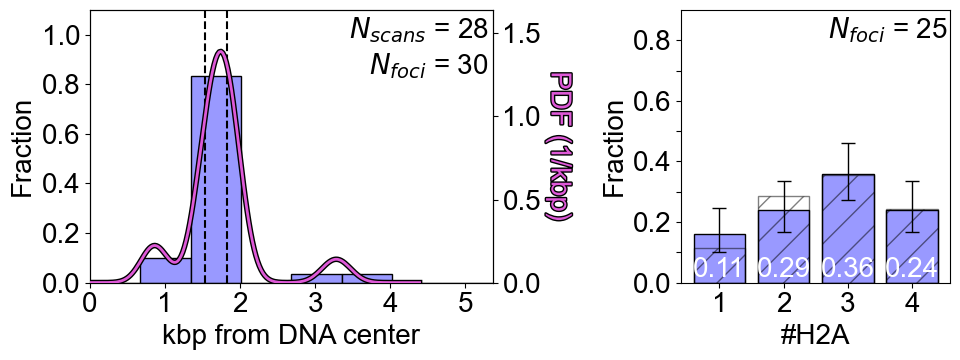

Changed it from 231, 233 to 232, 232


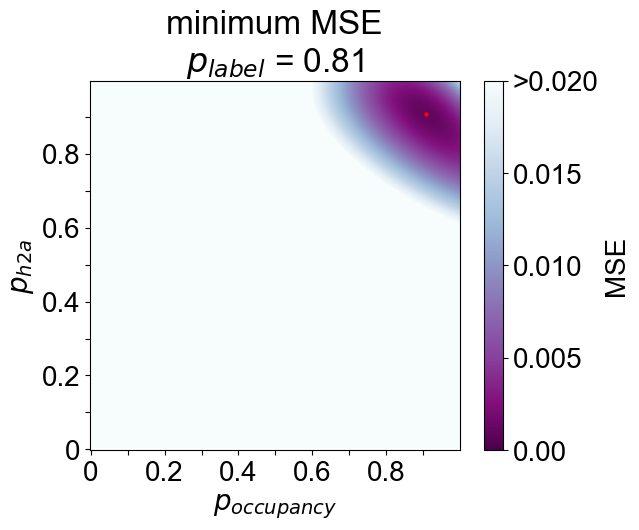

Optimal solution, only varying p_h2a: p_h2a = 0.9807417061905007
Resulting in stoichiometries [0.16909646 0.38533715 0.22664086 0.21892554]
MSE: 0.04356942401254529 

Optimal solution, varying p_h2a and p_occupancy: [p_h2a, p_occupancy] = [0.92554471 1.        ]
Resulting in stoichiometries [0.04721488 0.21211749 0.4235372  0.31713043]
MSE: 0.007065980870486561


Changed it from 237, 255 to 238, 255


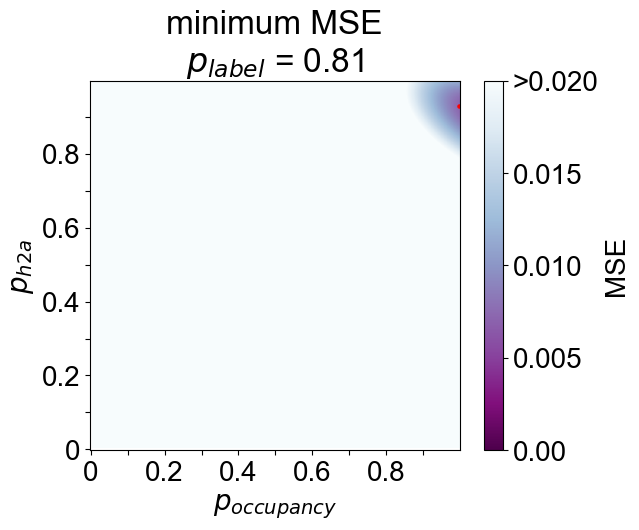

In [12]:
samples = ['S1', 'S2', 'S3', 'S4']
for s in samples:
    make_plot(data_dir, s)

## Figure 1.1

In [13]:
# Directory for figures data
data_dir = r'figure_data/Suplementary Figures/Figure 1.1'

In [14]:
def plot_lifetime(data,  color, ax):
    """Plot the lifetime data generated with get_lifetime()."""

    ax.plot(data['xvals'], data['yvals'], 'o', color='k')
    ax.plot(data['xvals'], data['yfit'], color=color, linewidth= 5)
    ax.annotate("$N_{dyes}$ = " + str(data['count']), xy=(0.99, 0.98),
                xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')
    ax.annotate("τ= %.2f " % data['mean_lifetime'] + data['t_unit']
                + " ± %.2f " % data['std'] + data['t_unit'], xy=(0.99, 0.85),
                xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')

    return fig, ax

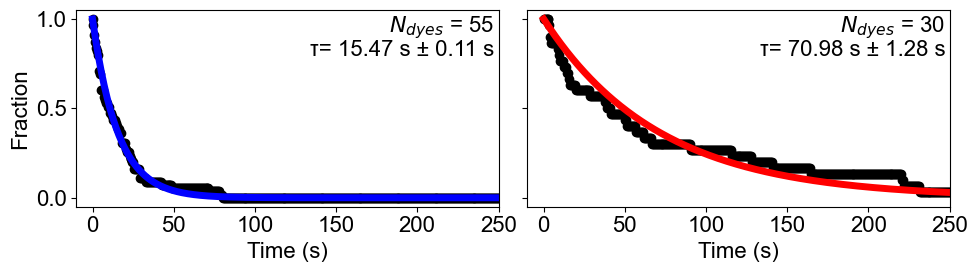

In [15]:
#################
# Lifetime plot #
#################

        
font = {'family':'arial', 'size'   : 16}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42

fig = plt.figure(constrained_layout=True,figsize=(10,3))
gs = GridSpec(1, 2, figure=fig)

ax1 = fig.add_subplot(gs[0])
with open(os.path.join(data_dir, "dataLTB.yaml"), "r") as file:
       dataLTB = yaml.safe_load(file)
plot_lifetime(dataLTB, 'b', ax1)
plt.xlim(-10, 250)

ax2 = fig.add_subplot(gs[1])
# Read data to plot
with open(os.path.join(data_dir, "dataLTR.yaml"), "r") as file:
       dataLTR = yaml.safe_load(file)
fig = plot_lifetime(dataLTR, 'r', ax2)
plt.xlim(-10, 250)
plt.yticks([0.0,0.5,1.0],[] )
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
# Show graphic
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax1.set_ylabel("Fraction")


plt.tight_layout()
plt.show()

## Figure 2

In [16]:
# Directory for figures data
data_dir = r'figure_data/Suplementary Figures/Figure 2'

In [17]:
def plot_stoichiometry(data, fig, ax, colors=None, edgecolor=None, filename=None, method='wilson',
                       significance=0.3173):
    """Make stoichiometry plot."""
    
    # Plot histogram.
    if colors is None:
        ax.bar(data['x'], data['freqs'], align='center', width=0.8, color='gray')
    else:
        ax.bar(data['x'], data['freqs'], align='center', width=0.8, color=colors, edgecolor=edgecolor)

    # Cleanup.
    ax.xaxis.set_major_locator(plt.FixedLocator(data['x']))
    ax.xaxis.set_major_formatter(plt.FixedFormatter(data['names']))
    plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    plt.ylim(0, 0.9)
    plt.annotate("$N_{foci}$ = " + str(data['n_traces']), xy=(0.99, 0.98),
                 xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')

    # Add standard error of the proportion
    n_obs = data['n_traces']
    errs = []
    for b, c in zip(data['x'], data['freqs']):
        if c == 0:
            err = [0, 0]
        else:
            err = list(statsmodels.stats.proportion.proportion_confint(c * n_obs, n_obs,
                                                                       alpha=significance, method=method))
            err[0] = c - err[0]
            err[1] = err[1] - c
        errs.append(err)
    errs = np.array(errs).swapaxes(0, 1)

    plt.errorbar(data['x'], data['freqs'], errs, fmt=' ', color='k', capsize=5, elinewidth=1, markeredgewidth=1)

    fig.tight_layout()

    if filename is not None:
        plt.savefig(filename)

    return fig, ax

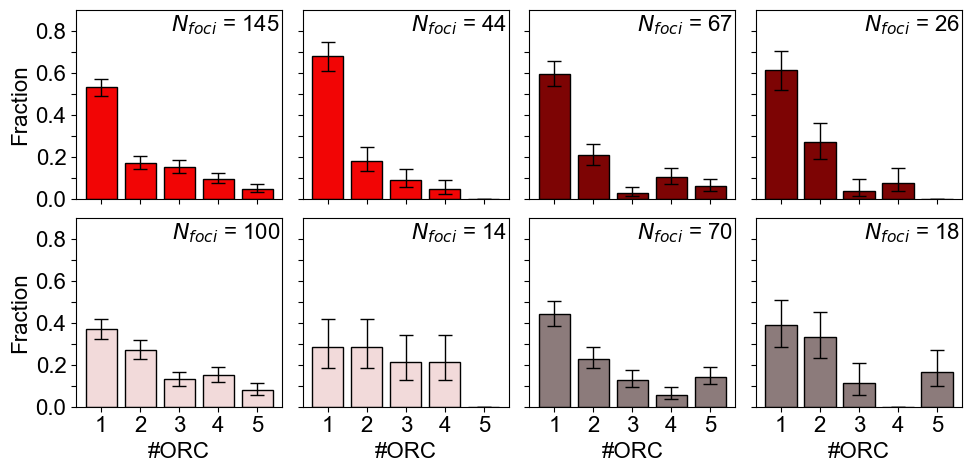

In [18]:
# Set congig
font = {'family':'arial', 'size'   : 16}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42

# Set parameters
bandw= binwidth/2
cut_v= 5
lw= 2
color_s= 'k'

# Make plot
figS2 = plt.figure(constrained_layout=True,figsize=(10, 5))
gs = figS2.add_gridspec(2, 4)

# Figure b) i. left
fS2_ax1 = figS2.add_subplot(gs[0, 0])
# Read data to plot
with open(os.path.join(data_dir, "datar0all8.yaml"), "r") as file:
    datar0all8 = yaml.safe_load(file)
plot_stoichiometry(datar0all8, figS2, fS2_ax1, '#f20505', edgecolor='k')
fS2_ax1.set_ylabel('Fraction')
fS2_ax1.set_xticklabels(([]))
fS2_ax1.set_yticklabels(('0.0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8'))

# Figure b) i. right
fS2_ax2 = figS2.add_subplot(gs[0, 1])
# Read data to plot
with open(os.path.join(data_dir, "datar0ori8.yaml"), "r") as file:
    datar0ori8 = yaml.safe_load(file)
plot_stoichiometry(datar0ori8, figS2, fS2_ax2,'#f20505', edgecolor='k')
fS2_ax2.set_xticklabels([])
fS2_ax2.set_yticklabels([])


# Figure b) ii. left
fS2_ax3 = figS2.add_subplot(gs[0, 2])
# Read data to plot
with open(os.path.join(data_dir, "datar0all7.yaml"), "r") as file:
    datar0all7 = yaml.safe_load(file)
plot_stoichiometry(datar0all7, figS2, fS2_ax3, '#7d0404', edgecolor='k')
fS2_ax3.set_xticklabels([])
fS2_ax3.set_yticklabels([])

# Figure b) ii. right
fS2_ax4 = figS2.add_subplot(gs[0, 3])
# Read data to plot
with open(os.path.join(data_dir, "datar0ori7.yaml"), "r") as file:
    datar0ori7 = yaml.safe_load(file)
plot_stoichiometry(datar0ori7, figS2, fS2_ax4, '#7d0404', edgecolor='k')
fS2_ax4.set_xticklabels([])
fS2_ax4.set_yticklabels([])


# Figure b) iii. left
fS2_ax5 = figS2.add_subplot(gs[-1, 0])
# Read data to plot
with open(os.path.join(data_dir, "datar0all26.yaml"), "r") as file:
    datar0all26 = yaml.safe_load(file)
plot_stoichiometry(datar0all26, figS2, fS2_ax5, '#f2dada', edgecolor='k')
fS2_ax5.set_xlabel("#ORC")
fS2_ax5.set_ylabel('Fraction')
fS2_ax5.set_xticklabels(('1','2','3','4','5'))
fS2_ax5.set_yticklabels(('0.0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8'))

# Figure b) iii. right
fS2_ax6 = figS2.add_subplot(gs[-1, 1])
# Read data to plot
with open(os.path.join(data_dir, "datar0ori26.yaml"), "r") as file:
    datar0ori26 = yaml.safe_load(file)
plot_stoichiometry(datar0ori26, figS2, fS2_ax6, '#f2dada', edgecolor='k')
fS2_ax6.set_xlabel("#ORC")
fS2_ax6.set_xticklabels(('1','2','3','4','5'))
fS2_ax6.set_yticklabels([])


# Figure b) iv. left
fS2_ax7 = figS2.add_subplot(gs[-1, 2])
# Read data to plot
with open(os.path.join(data_dir, "datar0all25.yaml"), "r") as file:
    datar0all25 = yaml.safe_load(file)
plot_stoichiometry(datar0all25, figS2, fS2_ax7, '#8c7b7b', edgecolor='k')
fS2_ax7.set_xlabel("#ORC")
fS2_ax7.set_xticklabels(('1','2','3','4','5'))
fS2_ax7.set_yticklabels([])

# Figure b) iv. right
fS2_ax8 = figS2.add_subplot(gs[-1, 3])
# Read data to plot
with open(os.path.join(data_dir, "datar0ori25.yaml"), "r") as file:
    datar0ori25 = yaml.safe_load(file)
plot_stoichiometry(datar0ori25, figS2, fS2_ax8, '#8c7b7b', edgecolor='k')
fS2_ax8.set_xlabel("#ORC")
fS2_ax8.set_xticklabels(('1','2','3','4','5'))
fS2_ax8.set_yticklabels([])

# Show graphic
gs.update(wspace=0.1, hspace=0.1)
plt.tight_layout()
plt.show()

## Figure 4.2

In [19]:
# Directory for figures data
data_dir = r'figure_data/Suplementary Figures/Figure 4.2'

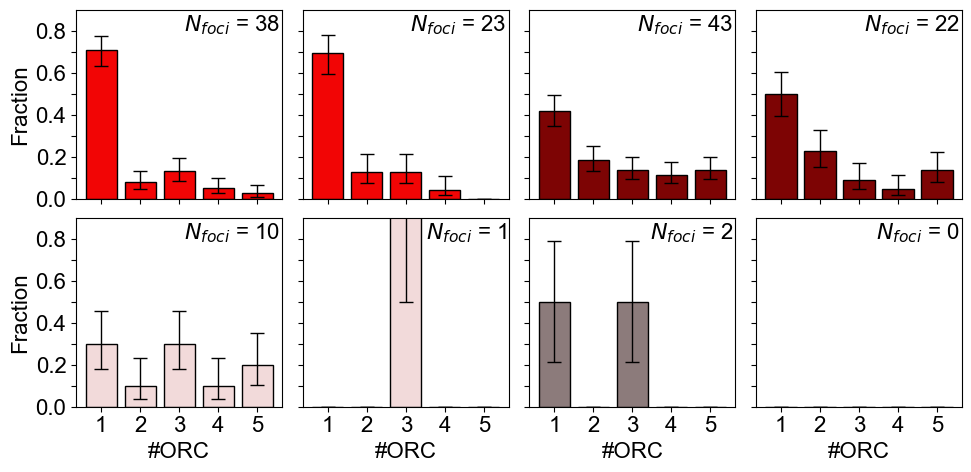

In [20]:
# Set config
font = {'family':'arial', 'size'   : 16}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42

# Set parameters
bandw= binwidth/2
cut_v= 5
lw= 2
color_s= 'k'

# Make plot
figS2b = plt.figure(constrained_layout=True,figsize=(10, 5))
gs = figS2b.add_gridspec(2, 4)

# Figure b) i. left
fS2b_ax1 = figS2b.add_subplot(gs[0, 0])
# Read data to plot
with open(os.path.join(data_dir, "datar0all4.yaml"), "r") as file:
    datar0all4 = yaml.safe_load(file)
plot_stoichiometry(datar0all4, figS2b, fS2b_ax1, '#f20505', edgecolor='k')
fS2b_ax1.set_ylabel('Fraction')
fS2b_ax1.set_xticklabels([])
fS2b_ax1.set_yticklabels(('0.0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8'))

# Figure b) i. right
fS2b_ax2 = figS2b.add_subplot(gs[0, 1])
# Read data to plot
with open(os.path.join(data_dir, "datar0ori4.yaml"), "r") as file:
    datar0ori4 = yaml.safe_load(file)
plot_stoichiometry(datar0ori4, figS2b, fS2b_ax2,'#f20505', edgecolor='k')
fS2b_ax2.set_xticklabels([])
fS2b_ax2.set_yticklabels([])


# Figure b) ii. left
fS2b_ax3 = figS2b.add_subplot(gs[0, 2])
# Read data to plot
with open(os.path.join(data_dir, "datar0all2.yaml"), "r") as file:
    datar0all2 = yaml.safe_load(file)
plot_stoichiometry(datar0all2, figS2b, fS2b_ax3, '#7d0404', edgecolor='k')
fS2b_ax3.set_xticklabels([])
fS2b_ax3.set_yticklabels([])

# Figure b) ii. right
fS2b_ax4 = figS2b.add_subplot(gs[0, 3])
# Read data to plot
with open(os.path.join(data_dir, "datar0ori2.yaml"), "r") as file:
    datar0ori2 = yaml.safe_load(file)
plot_stoichiometry(datar0ori2, figS2b, fS2b_ax4, '#7d0404', edgecolor='k')
fS2b_ax4.set_xticklabels([])
fS2b_ax4.set_yticklabels([])


# Figure b) iii. left
fS2b_ax5 = figS2b.add_subplot(gs[-1, 0])
# Read data to plot
with open(os.path.join(data_dir, "datar0all27.yaml"), "r") as file:
    datar0all27 = yaml.safe_load(file)
plot_stoichiometry(datar0all27, figS2b, fS2b_ax5, '#f2dada', edgecolor='k')
fS2b_ax5.set_xlabel("#ORC")
fS2b_ax5.set_ylabel('Fraction')
fS2b_ax5.set_xticklabels(('1','2','3','4','5'))
fS2b_ax5.set_yticklabels(('0.0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8'))

# Figure b) iii. right
fS2b_ax6 = figS2b.add_subplot(gs[-1, 1])
# Read data to plot
with open(os.path.join(data_dir, "datar0ori27.yaml"), "r") as file:
    datar0ori27 = yaml.safe_load(file)
plot_stoichiometry(datar0ori27, figS2b, fS2b_ax6, '#f2dada', edgecolor='k')
fS2b_ax6.set_xlabel("#ORC")
fS2b_ax6.set_xticklabels(('1','2','3','4','5'))
fS2b_ax6.set_yticklabels([])


# Figure b) iv. left
fS2b_ax7 = figS2b.add_subplot(gs[-1, 2])
# Read data to plot
with open(os.path.join(data_dir, "datar0all23.yaml"), "r") as file:
    datar0all23 = yaml.safe_load(file)
plot_stoichiometry(datar0all23, figS2b, fS2b_ax7, '#8c7b7b', edgecolor='k')
fS2b_ax7.set_xlabel("#ORC")
fS2b_ax7.set_xticklabels(('1','2','3','4','5'))
fS2b_ax7.set_yticklabels([])

# Figure b) iv. right
fS2b_ax8 = figS2b.add_subplot(gs[-1, 3])
# Read data to plot
with open(os.path.join(data_dir, "datar0ori23.yaml"), "r") as file:
    datar0ori23 = yaml.safe_load(file)
plot_stoichiometry(datar0ori23, figS2b, fS2b_ax8, '#8c7b7b', edgecolor='k')
fS2b_ax8.set_xlabel("#ORC")
fS2b_ax8.set_xticklabels(('1','2','3','4','5'))
fS2b_ax8.set_yticklabels([])

# Show figure
gs.update(wspace=0.1, hspace=0.1)
plt.tight_layout()
plt.show()


## Figure 3

In [21]:
# Directory for figures data
data_dir = r'figure_data/Suplementary Figures/Figure 3'

In [22]:
# Set config        
font = {'family':'arial', 'size'   :16}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42

# Create figure
figS2 = plt.figure(constrained_layout=True,figsize=(15, 7.5))
gs = figS2.add_gridspec(2, 4)

# Figure b) i. left
fS2_ax1 = figS2.add_subplot(gs[0, 0])
# Read data to plot
with open(os.path.join(data_dir, "dataLT8s.yaml"), "r") as file:
    dataLT8s = yaml.safe_load(file)
plot_lifetime(dataLT8s, '#f20505', fS2_ax1)
fS2_ax1.set_xlabel("Time (s)")
fS2_ax1.set_ylabel("Fraction")
plt.yticks([0.0,0.5,1.0],['0.0','0.5','1.0'] )

# Figure b) i. right
fS2_ax2 = figS2.add_subplot(gs[0, 1])
# Read data to plot
with open(os.path.join(data_dir, "dataLT8f.yaml"), "r") as file:
    dataLT8f = yaml.safe_load(file)
plot_lifetime(dataLT8f, '#f20505', fS2_ax2)
fS2_ax2.set_xlabel("Time (s)")
plt.yticks([0.0,0.5,1.0],[] )


# Figure b) ii. left
fS2_ax3 = figS2.add_subplot(gs[0, 2])
# Read data to plot
with open(os.path.join(data_dir, "dataLT7s.yaml"), "r") as file:
    dataLT7s = yaml.safe_load(file)
plot_lifetime(dataLT7s, '#7d0404', fS2_ax3)
fS2_ax3.set_xlabel("Time (s)")
plt.yticks([0.0,0.5,1.0],[] )

# Figure b) ii. right
fS2_ax4 = figS2.add_subplot(gs[0, 3])
# Read data to plot
with open(os.path.join(data_dir, "dataLT7f.yaml"), "r") as file:
    dataLT7f = yaml.safe_load(file)
plot_lifetime(dataLT7f, '#7d0404', fS2_ax4)
fS2_ax4.set_xlabel("Time (s)")
plt.yticks([0.0,0.5,1.0],[] )


# Figure b) iii. left
fS2_ax5 = figS2.add_subplot(gs[1, 0])
# Read data to plot
with open(os.path.join(data_dir, "dataLT26s.yaml"), "r") as file:
    dataLT26s = yaml.safe_load(file)
plot_lifetime(dataLT26s, '#f2dada', fS2_ax5)
fS2_ax5.set_xlabel("Time (s)")
fS2_ax5.set_ylabel("Fraction")
plt.yticks([0.0,0.5,1.0],['0.0','0.5','1.0'] )

# Figure b) iii. right
fS2_ax6 = figS2.add_subplot(gs[1, 1])
# Read data to plot
with open(os.path.join(data_dir, "dataLT26f.yaml"), "r") as file:
    dataLT26f = yaml.safe_load(file)
plot_lifetime(dataLT26f, '#f2dada', fS2_ax6)
fS2_ax6.set_xlabel("Time (s)")
plt.yticks([0.0,0.5,1.0],[] )


# Figure b) iv. left
fS2_ax7 = figS2.add_subplot(gs[1, 2])
# Read data to plot
with open(os.path.join(data_dir, "dataLT25s.yaml"), "r") as file:
    dataLT25s = yaml.safe_load(file)
plot_lifetime(dataLT25s,'#8c7b7b', fS2_ax7)
fS2_ax7.set_xlabel("Time (s)")
plt.yticks([0.0,0.5,1.0],[] )

# Figure b) iv. right
fS2_ax8 = figS2.add_subplot(gs[1, 3])
with open(os.path.join(data_dir, "dataLT25f.yaml"), "r") as file:
    dataLT25f = yaml.safe_load(file)
plot_lifetime(dataLT25f, '#8c7b7b', fS2_ax8)
fS2_ax8.set_xlabel("Time (s)")
plt.yticks([0.0,0.5,1.0],[] )

# Show graphic
plt.tight_layout()
plt.show()

## Figure 4.3

In [23]:
# Directory for figures data
data_dir = r'figure_data/Suplementary Figures/Figure 4.3'

In [24]:
def plot_stoichiometry(NN, data, fig, ax, colors=None, edgecolor=None, filename=None, method='wilson',
                       significance=0.3173):
    """Stoichiometry plot"""

    # Plot histogram.
    if not data['norm_per_scan']:
        plt.ylabel('Fraction')
    else:
        plt.ylabel('count per scan')
    if colors is None:
        ax.bar(data['x'], data['freqs'], align='center', width=0.8, color='gray')
    else:
        ax.bar(data['x'], data['freqs'], align='center', width=0.8, color=colors, edgecolor=edgecolor)

    # Cleanup.
    ax.xaxis.set_major_locator(plt.FixedLocator(data['x']))
    ax.xaxis.set_major_formatter(plt.FixedFormatter(data['names']))
    plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    plt.ylim(0, 0.9)
    plt.annotate("$N_{foci}$ = " + str(data['n_traces']), xy=(0.99, 0.98),
                 xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')

    # Add standard error of the proportion
    n_obs = data['n_traces']
    errs = []
    for b, c in zip(data['x'], data['freqs']):
        if c == 0:
            err = [0, 0]
        else:
            err = list(statsmodels.stats.proportion.proportion_confint(c * n_obs, n_obs,
                                                                       alpha=significance, method=method))
            err[0] = c - err[0]
            err[1] = err[1] - c
        errs.append(err)
    errs = np.array(errs).swapaxes(0, 1)

    plt.errorbar(data['x'], data['freqs'], errs, fmt=' ', color='k', capsize=5, elinewidth=1, markeredgewidth=1)

    fig.tight_layout()

    return fig, ax, errs

### b)

In [25]:
df_scans = pd.read_csv(os.path.join(data_dir, "b", "scans_example.csv"))
NN = len(df_scans['file_name'].unique())

In [26]:
# Set config
font = {'family':'arial', 'size'   : 20}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42

# Set parameters
bandw= binwidth/2
cut_v= 6
lw= 2
color_s= 'k'

# Create figure
fig = plt.figure(constrained_layout=True,figsize=(10, 4))
gs = GridSpec(1, 2, figure=fig, width_ratios=[1.5,1])

# Figure b) left
ax1 = fig.add_subplot(gs[0])
# Read data to plot
with open(os.path.join(data_dir, "b", "datar00bl.yaml"), "r") as file:
    datar00bl = yaml.safe_load(file)
plot_location_histogram(NN, fig, ax1, bandw, cut_v, lw, color_s, binwidth, datar00bl, '#9999ff' , edgecolor='k',
        ylim=0.8, vlines=[abs (dna_length/2 - NPS1), 
                        abs (dna_length/2 - NPS2)])
ax1.set_xlabel("kbp from DNA center")

# Figure b) center
ax3 = fig.add_subplot(gs[1])
# Read data to plot
with open(os.path.join(data_dir, "b", "datab0ori.yaml"), "r") as file:
    datab0ori = yaml.safe_load(file)
figH, axH, errs2= plot_stoichiometry(NN, datab0ori, fig, ax3, '#9999ff', edgecolor='k')

# Statisctics with stoichiometry
raw_countsrbST = np.array(datab0ori['total_spots'], dtype='int')

# Set probabilities
p_label = 0.81  # Labeling efficiency.
p_occupancy = 0.7  # Single site occupation probability.(from n_jumps)
p_data = np.array (datab0ori ['freqs']) 
p_data = p_data / np.sum(p_data)  # Make sure p_data is normalized.
# Calculate number of visible h2a from association probability and labeling efficiency.
def get_visible_h2a(p_h2a, p_l, p_occ):
    
    # Calculate chances of site occupation.
    p_occ0 = (1 - p_occ) ** 2
    p_occ1 = 2 * p_occ * (1 - p_occ)
    p_occ2 = p_occ ** 2
    
    # Calculate chances of tetrasome, hexasome, full nucleosome, if site is occupied.
    p_tet = (1 - p_h2a) ** 2
    p_hex = 2 * p_h2a * (1 - p_h2a)
    p_nuc = p_h2a ** 2
    
    # Calculate the probability distribution for the number of h2a (n) at the double NPS sites.
    # Not necessary to calculate p_n0
    p_n1 = p_occ1 * p_hex + \
           p_occ2 * 2 * p_tet * p_hex
    p_n2 = p_occ1 * p_nuc + \
           p_occ2 * (p_hex ** 2 + 2 * p_tet * p_nuc)
    p_n3 = p_occ2 * 2 * p_hex * p_nuc
    p_n4 = p_occ2 * p_nuc ** 2
    
    # Calculate the probability distribution for the number of visible  h2a (m).
    # Not necessary to calculate p_m0
    p_m1 = p_n1 * p_l + \
           p_n2 * 2 * p_l * (1 - p_l) + \
           p_n3 * 3 * p_l * (1 - p_l) ** 2 + \
           p_n4 * 4 * p_l * (1 - p_l) ** 3
    p_m2 = p_n2 * p_l ** 2 + \
           p_n3 * 3 * p_l ** 2 * (1 - p_l) + \
           p_n4 * 6 * p_l ** 2 * (1 - p_l) ** 2
    p_m3 = p_n3 * p_l ** 3 + \
           p_n4 * 4 * p_l ** 3 * (1 - p_l)
    p_m4 = p_n4 * p_l ** 4
    
    # Return normalized visible probabilities.
    p_array_visible = np.array([p_m1, p_m2, p_m3, p_m4])
    return p_array_visible / np.sum(p_array_visible)


# Calculate the MSE with scalar input.
def mse_h2a_scalar(p_h2a, p_l=p_label, p_occ=p_occupancy, p_experiment=p_data):
    p_predict = get_visible_h2a(p_h2a, p_l, p_occ)
    return np.mean((p_predict - p_experiment)**2)


# Calculate the MSE with p_h2a and p_occ as a tuple/array input.
def mse_h2a_tuple(p_tuple, p_l=p_label, p_experiment=p_data):
    p_h2a, p_occ = p_tuple
    p_predict = get_visible_h2a(p_h2a, p_l, p_occ)
    return np.mean((p_predict - p_experiment)**2)


# Prepare for parameter declarations.
overview_model = {}
# Varying only p_h2a.
res = scipy.optimize.minimize_scalar(mse_h2a_scalar)
print('Optimal solution, only varying p_h2a: p_h2a =', res.x)
print('Resulting in stoichiometries', get_visible_h2a(res.x, p_label, p_occupancy))
print('MSE:', res.fun, '\n')

overview_model ['Optimal solution, only varying p_h2a: p_h2a ='] = res.x
overview_model ['MSE_only varying p_h2a'] = res.fun

# Varying both probabilities.
res = scipy.optimize.minimize(mse_h2a_tuple, x0=[res.x, p_occupancy], bounds=[(0., 1.), (0., 1.)])
print('Optimal solution, varying p_h2a and p_occupancy: [p_h2a, p_occupancy] =', res.x)
print('Resulting in stoichiometries', get_visible_h2a(res.x[0], p_label, res.x[1]))
print('MSE:', res.fun)

overview_model ['Optimal solution, varying p_h2a and p_occupancy: p_h2a ='] = res.x
overview_model ['MSE_ varying p_h2a and p_occupancy'] = res.fun

with open(os.path.join(data_dir, "b",  "overview_model.yaml"), 'w') as file:
           documents = yaml.dump(overview_model, file)                                    
overview_model

# Plot bar
height = get_visible_h2a(res.x[0], p_label, res.x[1])
ax3.bar(datab0ori['x'], height, alpha=0.5,  fill=False, edgecolor='black', hatch="/")

for xval, fval in zip(datab0ori['x'], height):
    ax3.text(xval, 0.02, "%.2f" % fval, horizontalalignment='center', color = 'white')

ax3.set_xlabel("#H2A")
ax3.set_xticklabels(('1','2','3','4'))
ax3.set_yticklabels(('0.0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8'))
plt.show()

Optimal solution, only varying p_h2a: p_h2a = 0.6903414558334344
Resulting in stoichiometries [0.37159097 0.38272746 0.1865293  0.05915227]
MSE: 0.0010708492542317182 

Optimal solution, varying p_h2a and p_occupancy: [p_h2a, p_occupancy] = [0.8069716  0.52108981]
Resulting in stoichiometries [0.36143773 0.41981186 0.14862711 0.0701233 ]
MSE: 0.00017555363401585645


In [27]:
# Plot MSE landscape.
font = {'family':'arial', 'size'   : 20}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
n_pixels = 256
p_map = np.zeros((n_pixels, n_pixels))
p_min = np.zeros((n_pixels, n_pixels, 4))
for x in range(n_pixels):
    for y in range(n_pixels):
        p_h2a = x / n_pixels
        p_o = y / n_pixels
        z = mse_h2a_scalar(p_h2a, p_label, p_o)
        p_map[x, y] = z
mse_min = np.amin(p_map[~np.isnan(p_map)].flatten())
x_min = np.nan
y_min = np.nan
for x in range(n_pixels):
    for y in range(n_pixels):
        if p_map[x, y] < mse_min * 1.001:
            p_min[x, y] = (1, 0, 0, 1)
            if not np.isnan(x_min):
                print('Warning: x_min, y_min already set...')
                print(f'Changed it from {x_min}, {y_min} to {x}, {y}')
            x_min = x
            y_min = y
        else:
            p_min[x, y] = (0, 0, 0, 0)

In [28]:
# Figure b) right
plt.figure()
plt.imshow(p_map, origin='lower', cmap='BuPu_r', vmin=0, vmax=0.02)
cbar = plt.colorbar(label='MSE', ticks=[0., 0.005, 0.01, 0.015, 0.02])
cbar.ax.set_yticklabels(['0.00', '0.005', '0.010', '0.015', '>0.020'])
plt.scatter([y_min], [x_min], c='r', s=5)
plt.xlabel('$p_{occupancy}$')#'$x_{my text}$'  p_occupancy
plt.ylabel('$p_{h2a}$')
plt.title('minimum MSE\n$p_{label}$ = %.2f' % p_label)
plt.yticks(np.arange(0, n_pixels+1, n_pixels/10), ('0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8',' ', '1' ))
plt.xticks(np.arange(0, n_pixels+1, n_pixels/10), ('0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8',' ', '1' ))
plt.show()


### c)

In [29]:
df_scans = pd.read_csv(os.path.join(data_dir, "c", "scans_example.csv"))
NN = len(df_scans['file_name'].unique())

In [30]:
# Set config
font = {'family':'arial', 'size'   : 20}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42

# Set parameters
bandw= binwidth/2
cut_v= 6
lw= 2
color_s= 'k'

# Create figure
fig = plt.figure(constrained_layout=True,figsize=(10, 4))
gs = GridSpec(1, 2, figure=fig, width_ratios=[1.5,1])

# Figure c) left
ax1 = fig.add_subplot(gs[0])
# Read data to plot
with open(os.path.join(data_dir, "c", "datar00bl.yaml"), "r") as file:
    datar00bl = yaml.safe_load(file)
plot_location_histogram(NN, fig, ax1, bandw, cut_v, lw, color_s, binwidth, datar00bl, '#9999ff' , edgecolor='k',
        ylim=0.8, vlines=[abs (dna_length/2 - NPS1), 
                        abs (dna_length/2 - NPS2)])
ax1.set_xlabel("kbp from DNA center")

# Figure c) center
ax3 = fig.add_subplot(gs[1])
# Read data to plot
with open(os.path.join(data_dir, "c", "datab0ori.yaml"), "r") as file:
    datab0ori = yaml.safe_load(file)
figH, axH, errs2= plot_stoichiometry(NN, datab0ori, fig, ax3, '#9999ff', edgecolor='k')

# Statisctics with stoichiometry
raw_countsrbST = np.array(datab0ori['total_spots'], dtype='int')

# Set probabilities
p_label = 0.81  # Labeling efficiency.
p_occupancy = 0.7  # Single site occupation probability.(from n_jumps)
p_data = np.array (datab0ori ['freqs']) 
p_data = p_data / np.sum(p_data)  # Make sure p_data is normalized.
# Calculate number of visible h2a from association probability and labeling efficiency.
def get_visible_h2a(p_h2a, p_l, p_occ):
    
    # Calculate chances of site occupation.
    p_occ0 = (1 - p_occ) ** 2
    p_occ1 = 2 * p_occ * (1 - p_occ)
    p_occ2 = p_occ ** 2
    
    # Calculate chances of tetrasome, hexasome, full nucleosome, if site is occupied.
    p_tet = (1 - p_h2a) ** 2
    p_hex = 2 * p_h2a * (1 - p_h2a)
    p_nuc = p_h2a ** 2
    
    # Calculate the probability distribution for the number of h2a (n) at the double NPS sites.
    # Not necessary to calculate p_n0
    p_n1 = p_occ1 * p_hex + \
           p_occ2 * 2 * p_tet * p_hex
    p_n2 = p_occ1 * p_nuc + \
           p_occ2 * (p_hex ** 2 + 2 * p_tet * p_nuc)
    p_n3 = p_occ2 * 2 * p_hex * p_nuc
    p_n4 = p_occ2 * p_nuc ** 2
    
    # Calculate the probability distribution for the number of visible  h2a (m).
    # Not necessary to calculate p_m0
    p_m1 = p_n1 * p_l + \
           p_n2 * 2 * p_l * (1 - p_l) + \
           p_n3 * 3 * p_l * (1 - p_l) ** 2 + \
           p_n4 * 4 * p_l * (1 - p_l) ** 3
    p_m2 = p_n2 * p_l ** 2 + \
           p_n3 * 3 * p_l ** 2 * (1 - p_l) + \
           p_n4 * 6 * p_l ** 2 * (1 - p_l) ** 2
    p_m3 = p_n3 * p_l ** 3 + \
           p_n4 * 4 * p_l ** 3 * (1 - p_l)
    p_m4 = p_n4 * p_l ** 4
    
    # Return normalized visible probabilities.
    p_array_visible = np.array([p_m1, p_m2, p_m3, p_m4])
    return p_array_visible / np.sum(p_array_visible)


# Calculate the MSE with scalar input.
def mse_h2a_scalar(p_h2a, p_l=p_label, p_occ=p_occupancy, p_experiment=p_data):
    p_predict = get_visible_h2a(p_h2a, p_l, p_occ)
    return np.mean((p_predict - p_experiment)**2)


# Calculate the MSE with p_h2a and p_occ as a tuple/array input.
def mse_h2a_tuple(p_tuple, p_l=p_label, p_experiment=p_data):
    p_h2a, p_occ = p_tuple
    p_predict = get_visible_h2a(p_h2a, p_l, p_occ)
    return np.mean((p_predict - p_experiment)**2)


# Prepare for parameter declarations.
overview_model = {}
# Varying only p_h2a.
res = scipy.optimize.minimize_scalar(mse_h2a_scalar)
print('Optimal solution, only varying p_h2a: p_h2a =', res.x)
print('Resulting in stoichiometries', get_visible_h2a(res.x, p_label, p_occupancy))
print('MSE:', res.fun, '\n')

overview_model ['Optimal solution, only varying p_h2a: p_h2a ='] = res.x
overview_model ['MSE_only varying p_h2a'] = res.fun

# Varying both probabilities.
res = scipy.optimize.minimize(mse_h2a_tuple, x0=[res.x, p_occupancy], bounds=[(0., 1.), (0., 1.)])
print('Optimal solution, varying p_h2a and p_occupancy: [p_h2a, p_occupancy] =', res.x)
print('Resulting in stoichiometries', get_visible_h2a(res.x[0], p_label, res.x[1]))
print('MSE:', res.fun)

overview_model ['Optimal solution, varying p_h2a and p_occupancy: p_h2a ='] = res.x
overview_model ['MSE_ varying p_h2a and p_occupancy'] = res.fun

with open(os.path.join(data_dir, "c",  "overview_model.yaml"), 'w') as file:
           documents = yaml.dump(overview_model, file)                                    
overview_model

# Plot bar
height = get_visible_h2a(res.x[0], p_label, res.x[1])
ax3.bar(datab0ori['x'], height, alpha=0.5,  fill=False, edgecolor='black', hatch="/")

for xval, fval in zip(datab0ori['x'], height):
    ax3.text(xval, 0.02, "%.2f" % fval, horizontalalignment='center', color = 'white')

ax3.set_xlabel("#H2A")
ax3.set_xticklabels(('1','2','3','4'))
ax3.set_yticklabels(('0.0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8'))
plt.show()

Optimal solution, only varying p_h2a: p_h2a = 0.6027289624253367
Resulting in stoichiometries [0.44124331 0.3701234  0.15231008 0.03632322]
MSE: 0.00048493768985095745 

Optimal solution, varying p_h2a and p_occupancy: [p_h2a, p_occupancy] = [0.59336346 0.7170167 ]
Resulting in stoichiometries [0.44120828 0.36990823 0.1533958  0.03548769]
MSE: 0.00048175766400594623


In [31]:
# Plot MSE landscape.
font = {'family':'arial', 'size'   : 20}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
n_pixels = 256
p_map = np.zeros((n_pixels, n_pixels))
p_min = np.zeros((n_pixels, n_pixels, 4))
for x in range(n_pixels):
    for y in range(n_pixels):
        p_h2a = x / n_pixels
        p_o = y / n_pixels
        z = mse_h2a_scalar(p_h2a, p_label, p_o)
        p_map[x, y] = z
mse_min = np.amin(p_map[~np.isnan(p_map)].flatten())
x_min = np.nan
y_min = np.nan
for x in range(n_pixels):
    for y in range(n_pixels):
        if p_map[x, y] < mse_min * 1.001:
            p_min[x, y] = (1, 0, 0, 1)
            if not np.isnan(x_min):
                print('Warning: x_min, y_min already set...')
                print(f'Changed it from {x_min}, {y_min} to {x}, {y}')
            x_min = x
            y_min = y
        else:
            p_min[x, y] = (0, 0, 0, 0)

Changed it from 151, 185 to 152, 183
Changed it from 152, 183 to 152, 184
Changed it from 152, 184 to 153, 182


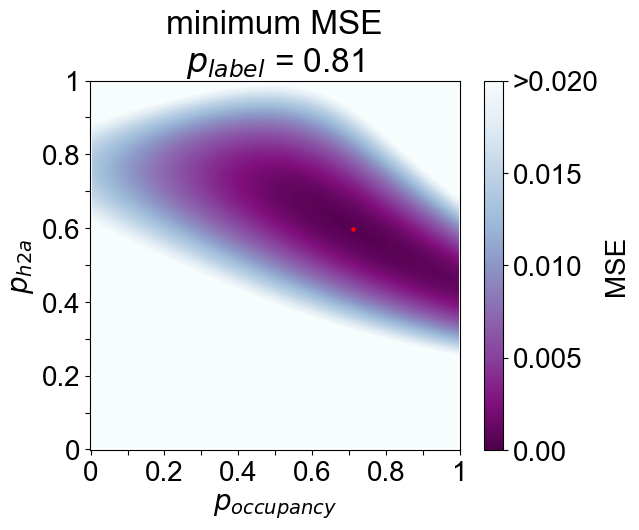

In [32]:
# Figure c) right
plt.figure()
plt.imshow(p_map, origin='lower', cmap='BuPu_r', vmin=0, vmax=0.02)
cbar = plt.colorbar(label='MSE', ticks=[0., 0.005, 0.01, 0.015, 0.02])
cbar.ax.set_yticklabels(['0.00', '0.005', '0.010', '0.015', '>0.020'])
plt.scatter([y_min], [x_min], c='r', s=5)
plt.xlabel('$p_{occupancy}$')#'$x_{my text}$'  p_occupancy
plt.ylabel('$p_{h2a}$')
plt.title('minimum MSE\n$p_{label}$ = %.2f' % p_label)
plt.yticks(np.arange(0, n_pixels+1, n_pixels/10), ('0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8',' ', '1' ))
plt.xticks(np.arange(0, n_pixels+1, n_pixels/10), ('0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8',' ', '1' ))
plt.show()

## Figure 5.1

In [33]:
# Directory for figures data
data_dir = r'figure_data/Suplementary Figures/Figure 5.1'

In [34]:
def plot_stoichiometry(data, fig, ax, colors=None, edgecolor=None, filename=None, method='wilson',
                       significance=0.3173):
    """Plot stoichiometry"""

    if colors is None:
        ax.bar(data['x'], data['freqs'], align='center', width=0.8, color='gray')
    else:
        ax.bar(data['x'], data['freqs'], align='center', width=0.8, color=colors, edgecolor=edgecolor)

    # Cleanup.
    ax.xaxis.set_major_locator(plt.FixedLocator(data['x']))
    ax.xaxis.set_major_formatter(plt.FixedFormatter(data['names']))
    plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    plt.ylim(0, 0.9)
    plt.annotate("$N_{foci}$ = " + str(data['n_traces']), xy=(0.99, 0.98),
                 xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')

    # Add standard error of the proportion
    n_obs = data['n_traces']
    errs = []
    for b, c in zip(data['x'], data['freqs']):
        if c == 0:
            err = [0, 0]
        else:
            err = list(statsmodels.stats.proportion.proportion_confint(c * n_obs, n_obs,
                                                                       alpha=significance, method=method))
            err[0] = c - err[0]
            err[1] = err[1] - c
        errs.append(err)
    errs = np.array(errs).swapaxes(0, 1)

    plt.errorbar(data['x'], data['freqs'], errs, fmt=' ', color='k', capsize=5, elinewidth=1, markeredgewidth=1)
    if filename is not None:
        plt.savefig(filename)

    return fig, ax

In [35]:
# Set config
font = {'family':'arial', 'size'   : 16}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42

# Set parameters
bandw= binwidth/2
cut_v= 5
lw= 2
color_s= 'k'

# Create figure
figS2 = plt.figure(constrained_layout=True,figsize=(10, 5))
gs = figS2.add_gridspec(2, 4)

# Figure i. left
fS2_ax1 = figS2.add_subplot(gs[0, 0])
# Read data to plot
with open(os.path.join(data_dir, "datar0all5.yaml"), "r") as file:
    datar0all5 = yaml.safe_load(file)
plot_stoichiometry(datar0all5, figS2, fS2_ax1, '#ed5d32', edgecolor='k')
fS2_ax1.set_ylabel('Fraction')
fS2_ax1.set_xticklabels([])
fS2_ax1.set_yticklabels(('0.0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8'))

# Figure i. right
fS2_ax2 = figS2.add_subplot(gs[0, 1])
# Read data to plot
with open(os.path.join(data_dir, "datar0ori5.yaml"), "r") as file:
    datar0ori5 = yaml.safe_load(file)
plot_stoichiometry(datar0ori5, figS2, fS2_ax2,'#ed5d32', edgecolor='k')
fS2_ax2.set_xticklabels([])
fS2_ax2.set_yticklabels(('', ' ','',' ','',' ','',' ', ''))


# Figure ii. left
fS2_ax3 = figS2.add_subplot(gs[0, 2])
# Read data to plot
with open(os.path.join(data_dir, "datar0all3.yaml"), "r") as file:
    datar0all3 = yaml.safe_load(file)
plot_stoichiometry(datar0all3, figS2, fS2_ax3, '#69230e', edgecolor='k')
fS2_ax3.set_xticklabels([])
fS2_ax3.set_yticklabels([])

# Figure ii. right
fS2_ax4 = figS2.add_subplot(gs[0, 3])
# Read data to plot
with open(os.path.join(data_dir, "datar0ori3.yaml"), "r") as file:
    datar0ori3 = yaml.safe_load(file)
plot_stoichiometry(datar0ori3, figS2, fS2_ax4, '#69230e', edgecolor='k')
fS2_ax4.set_xticklabels([])
fS2_ax4.set_yticklabels([])



# Figure iii. left
fS2_ax5 = figS2.add_subplot(gs[-1, 0])
# Read data to plot
with open(os.path.join(data_dir, "datar0all29.yaml"), "r") as file:
    datar0all29 = yaml.safe_load(file)
plot_stoichiometry(datar0all29, figS2, fS2_ax5,'#d1a99d', edgecolor='k')
fS2_ax5.set_xlabel("#MCM")
fS2_ax5.set_ylabel('Fraction')
fS2_ax5.set_xticklabels(('1','2','3','4','5'))
fS2_ax5.set_yticklabels(('0.0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8'))

# Figure iii. right
fS2_ax6 = figS2.add_subplot(gs[-1, 1])
# Read data to plot
with open(os.path.join(data_dir, "datar0ori29.yaml"), "r") as file:
    datar0ori29 = yaml.safe_load(file)
plot_stoichiometry(datar0ori29, figS2, fS2_ax6, '#d1a99d', edgecolor='k')
fS2_ax6.set_xlabel("#MCM")
fS2_ax6.set_xticklabels(('1','2','3','4','5'))
fS2_ax6.set_yticklabels(('', ' ','',' ','',' ','',' ', ''))


# Figure iv. left
fS2_ax7 = figS2.add_subplot(gs[-1, 2])
# Read data to plot
with open(os.path.join(data_dir, "datar0all28.yaml"), "r") as file:
    datar0all28 = yaml.safe_load(file)
plot_stoichiometry(datar0all28, figS2, fS2_ax7, '#4f3932', edgecolor='k')
fS2_ax7.set_xlabel("#MCM")
fS2_ax7.set_xticklabels(('1','2','3','4','5'))
fS2_ax7.set_yticklabels(('', ' ','',' ','',' ','',' ', ''))

# Figure iv. right
fS2_ax8 = figS2.add_subplot(gs[-1, 3])
# Read data to plot
with open(os.path.join(data_dir, "datar0ori28.yaml"), "r") as file:
    datar0ori28 = yaml.safe_load(file)
plot_stoichiometry(datar0ori28, figS2, fS2_ax8, '#4f3932', edgecolor='k')
fS2_ax8.set_xlabel("#MCM")
fS2_ax8.set_xticklabels(('1','2','3','4','5'))
fS2_ax8.set_yticklabels(('', ' ','',' ','',' ','',' ', ''))

# Show graphics
gs.update(hspace=0.1)
plt.show()

## Figure 5.2

In [36]:
# Directory for figures data
data_dir = r'figure_data/Suplementary Figures/Figure 5.2'

In [37]:
def plot_stoichiometry(NN, data, fig, ax, colors=None, edgecolor=None, filename=None, method='wilson',
                       significance=0.3173):
    """Stoichiometry plot"""

    # Plot histogram.
    if not data['norm_per_scan']:
        plt.ylabel('Fraction')
    else:
        plt.ylabel('count per scan')
    if colors is None:
        ax.bar(data['x'], data['freqs'], align='center', width=0.8, color='gray')
    else:
        ax.bar(data['x'], data['freqs'], align='center', width=0.8, color=colors, edgecolor=edgecolor)

    # Cleanup.
    ax.xaxis.set_major_locator(plt.FixedLocator(data['x']))
    ax.xaxis.set_major_formatter(plt.FixedFormatter(data['names']))
    plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    plt.ylim(0, 0.9)
    plt.annotate("$N_{foci}$ = " + str(data['n_traces']), xy=(0.99, 0.98),
                 xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')

    # Add standard error of the proportion
    n_obs = data['n_traces']
    errs = []
    for b, c in zip(data['x'], data['freqs']):
        if c == 0:
            err = [0, 0]
        else:
            err = list(statsmodels.stats.proportion.proportion_confint(c * n_obs, n_obs,
                                                                       alpha=significance, method=method))
            err[0] = c - err[0]
            err[1] = err[1] - c
        errs.append(err)
    errs = np.array(errs).swapaxes(0, 1)

    plt.errorbar(data['x'], data['freqs'], errs, fmt=' ', color='k', capsize=5, elinewidth=1, markeredgewidth=1)

    fig.tight_layout()

    return fig, ax, errs

### b)

In [38]:
df_scans = pd.read_csv(os.path.join(data_dir, "b", "scans_example.csv"))
NN = len(df_scans['file_name'].unique())

Optimal solution, only varying p_h2a: p_h2a = 0.9513117927444231
Resulting in stoichiometries [0.18809222 0.38495699 0.2320862  0.19486459]
MSE: 0.003190445666415284 

Optimal solution, varying p_h2a and p_occupancy: [p_h2a, p_occupancy] = [0.84309219 0.88763483]
Resulting in stoichiometries [0.16158184 0.32803964 0.33175792 0.1786206 ]
MSE: 9.903810359134874e-05


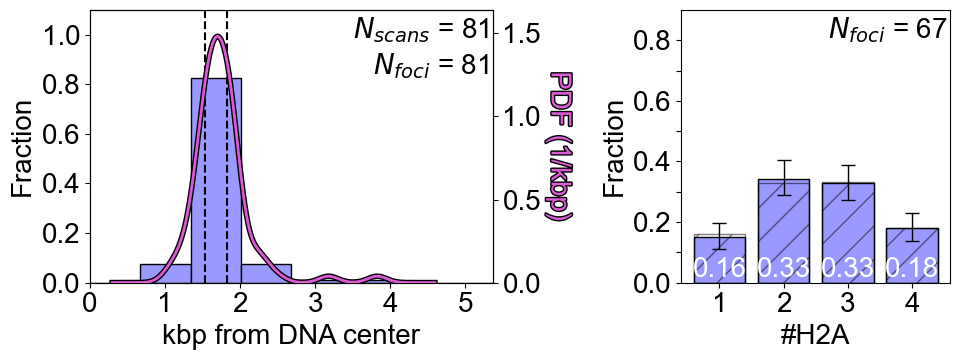

In [39]:
# Set config
font = {'family':'arial', 'size'   : 20}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42

# Set parameters
bandw= binwidth/2
cut_v= 6
lw= 2
color_s= 'k'

# Create figure
fig = plt.figure(constrained_layout=True,figsize=(10, 4))
gs = GridSpec(1, 2, figure=fig, width_ratios=[1.5,1])

# Figure b) left
ax1 = fig.add_subplot(gs[0])
# Read data to plot
with open(os.path.join(data_dir, "b", "datar00bl.yaml"), "r") as file:
    datar00bl = yaml.safe_load(file)
plot_location_histogram(NN, fig, ax1, bandw, cut_v, lw, color_s, binwidth, datar00bl, '#9999ff' , edgecolor='k',
        ylim=0.8, vlines=[abs (dna_length/2 - NPS1), 
                        abs (dna_length/2 - NPS2)])
ax1.set_xlabel("kbp from DNA center")

# Figure b) center
ax3 = fig.add_subplot(gs[1])
# Read data to plot
with open(os.path.join(data_dir, "b", "datab0ori.yaml"), "r") as file:
    datab0ori = yaml.safe_load(file)
figH, axH, errs2= plot_stoichiometry(NN, datab0ori, fig, ax3, '#9999ff', edgecolor='k')

# Statisctics with stoichiometry
raw_countsrbST = np.array(datab0ori['total_spots'], dtype='int')

# Set probabilities
p_label = 0.81  # Labeling efficiency.
p_occupancy = 0.7  # Single site occupation probability.(from n_jumps)
p_data = np.array (datab0ori ['freqs']) 
p_data = p_data / np.sum(p_data)  # Make sure p_data is normalized.
# Calculate number of visible h2a from association probability and labeling efficiency.
def get_visible_h2a(p_h2a, p_l, p_occ):
    
    # Calculate chances of site occupation.
    p_occ0 = (1 - p_occ) ** 2
    p_occ1 = 2 * p_occ * (1 - p_occ)
    p_occ2 = p_occ ** 2
    
    # Calculate chances of tetrasome, hexasome, full nucleosome, if site is occupied.
    p_tet = (1 - p_h2a) ** 2
    p_hex = 2 * p_h2a * (1 - p_h2a)
    p_nuc = p_h2a ** 2
    
    # Calculate the probability distribution for the number of h2a (n) at the double NPS sites.
    # Not necessary to calculate p_n0
    p_n1 = p_occ1 * p_hex + \
           p_occ2 * 2 * p_tet * p_hex
    p_n2 = p_occ1 * p_nuc + \
           p_occ2 * (p_hex ** 2 + 2 * p_tet * p_nuc)
    p_n3 = p_occ2 * 2 * p_hex * p_nuc
    p_n4 = p_occ2 * p_nuc ** 2
    
    # Calculate the probability distribution for the number of visible  h2a (m).
    # Not necessary to calculate p_m0
    p_m1 = p_n1 * p_l + \
           p_n2 * 2 * p_l * (1 - p_l) + \
           p_n3 * 3 * p_l * (1 - p_l) ** 2 + \
           p_n4 * 4 * p_l * (1 - p_l) ** 3
    p_m2 = p_n2 * p_l ** 2 + \
           p_n3 * 3 * p_l ** 2 * (1 - p_l) + \
           p_n4 * 6 * p_l ** 2 * (1 - p_l) ** 2
    p_m3 = p_n3 * p_l ** 3 + \
           p_n4 * 4 * p_l ** 3 * (1 - p_l)
    p_m4 = p_n4 * p_l ** 4
    
    # Return normalized visible probabilities.
    p_array_visible = np.array([p_m1, p_m2, p_m3, p_m4])
    return p_array_visible / np.sum(p_array_visible)


# Calculate the MSE with scalar input.
def mse_h2a_scalar(p_h2a, p_l=p_label, p_occ=p_occupancy, p_experiment=p_data):
    p_predict = get_visible_h2a(p_h2a, p_l, p_occ)
    return np.mean((p_predict - p_experiment)**2)


# Calculate the MSE with p_h2a and p_occ as a tuple/array input.
def mse_h2a_tuple(p_tuple, p_l=p_label, p_experiment=p_data):
    p_h2a, p_occ = p_tuple
    p_predict = get_visible_h2a(p_h2a, p_l, p_occ)
    return np.mean((p_predict - p_experiment)**2)


# Prepare for parameter declarations.
overview_model = {}
# Varying only p_h2a.
res = scipy.optimize.minimize_scalar(mse_h2a_scalar)
print('Optimal solution, only varying p_h2a: p_h2a =', res.x)
print('Resulting in stoichiometries', get_visible_h2a(res.x, p_label, p_occupancy))
print('MSE:', res.fun, '\n')

overview_model ['Optimal solution, only varying p_h2a: p_h2a ='] = res.x
overview_model ['MSE_only varying p_h2a'] = res.fun

# Varying both probabilities.
res = scipy.optimize.minimize(mse_h2a_tuple, x0=[res.x, p_occupancy], bounds=[(0., 1.), (0., 1.)])
print('Optimal solution, varying p_h2a and p_occupancy: [p_h2a, p_occupancy] =', res.x)
print('Resulting in stoichiometries', get_visible_h2a(res.x[0], p_label, res.x[1]))
print('MSE:', res.fun)

overview_model ['Optimal solution, varying p_h2a and p_occupancy: p_h2a ='] = res.x
overview_model ['MSE_ varying p_h2a and p_occupancy'] = res.fun

with open(os.path.join(data_dir, "b",  "overview_model.yaml"), 'w') as file:
           documents = yaml.dump(overview_model, file)                                    
overview_model

# Plot bar
height = get_visible_h2a(res.x[0], p_label, res.x[1])
ax3.bar(datab0ori['x'], height, alpha=0.5,  fill=False, edgecolor='black', hatch="/")

for xval, fval in zip(datab0ori['x'], height):
    ax3.text(xval, 0.02, "%.2f" % fval, horizontalalignment='center', color = 'white')

ax3.set_xlabel("#H2A")
ax3.set_xticklabels(('1','2','3','4'))
ax3.set_yticklabels(('0.0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8'))
plt.show()

In [40]:
# Plot MSE landscape.
font = {'family':'arial', 'size'   : 20}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
n_pixels = 256
p_map = np.zeros((n_pixels, n_pixels))
p_min = np.zeros((n_pixels, n_pixels, 4))
for x in range(n_pixels):
    for y in range(n_pixels):
        p_h2a = x / n_pixels
        p_o = y / n_pixels
        z = mse_h2a_scalar(p_h2a, p_label, p_o)
        p_map[x, y] = z
mse_min = np.amin(p_map[~np.isnan(p_map)].flatten())
x_min = np.nan
y_min = np.nan
for x in range(n_pixels):
    for y in range(n_pixels):
        if p_map[x, y] < mse_min * 1.001:
            p_min[x, y] = (1, 0, 0, 1)
            if not np.isnan(x_min):
                print('Warning: x_min, y_min already set...')
                print(f'Changed it from {x_min}, {y_min} to {x}, {y}')
            x_min = x
            y_min = y
        else:
            p_min[x, y] = (0, 0, 0, 0)

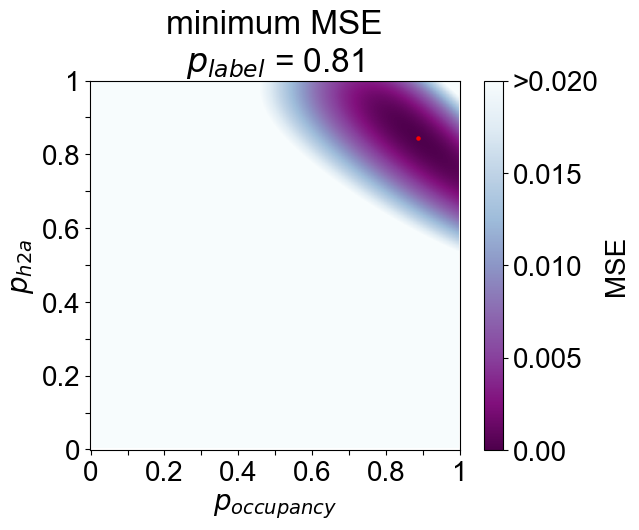

In [41]:
# Figure b) right
plt.figure()
plt.imshow(p_map, origin='lower', cmap='BuPu_r', vmin=0, vmax=0.02)
cbar = plt.colorbar(label='MSE', ticks=[0., 0.005, 0.01, 0.015, 0.02])
cbar.ax.set_yticklabels(['0.00', '0.005', '0.010', '0.015', '>0.020'])
plt.scatter([y_min], [x_min], c='r', s=5)
plt.xlabel('$p_{occupancy}$')#'$x_{my text}$'  p_occupancy
plt.ylabel('$p_{h2a}$')
plt.title('minimum MSE\n$p_{label}$ = %.2f' % p_label)
plt.yticks(np.arange(0, n_pixels+1, n_pixels/10), ('0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8',' ', '1' ))
plt.xticks(np.arange(0, n_pixels+1, n_pixels/10), ('0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8',' ', '1' ))
plt.show()

### c)

In [42]:
# Set config
font = {'family':'arial', 'size'   : 20}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42

# Set parameters
bandw= binwidth/2
cut_v= 6
lw= 2
color_s= 'k'

# Create figure
fig = plt.figure(constrained_layout=True,figsize=(10, 4))
gs = GridSpec(1, 2, figure=fig, width_ratios=[1.5,1])

# Figure c) left
ax1 = fig.add_subplot(gs[0])
# Read data to plot
with open(os.path.join(data_dir, "c", "datar00bl.yaml"), "r") as file:
    datar00bl = yaml.safe_load(file)
plot_location_histogram(NN, fig, ax1, bandw, cut_v, lw, color_s, binwidth, datar00bl, '#9999ff' , edgecolor='k',
        ylim=0.8, vlines=[abs (dna_length/2 - NPS1), 
                        abs (dna_length/2 - NPS2)])
ax1.set_xlabel("kbp from DNA center")

# Figure c) center
ax3 = fig.add_subplot(gs[1])
# Read data to plot
with open(os.path.join(data_dir, "c", "datab0ori.yaml"), "r") as file:
    datab0ori = yaml.safe_load(file)
figH, axH, errs2= plot_stoichiometry(NN, datab0ori, fig, ax3, '#9999ff', edgecolor='k')

# Statisctics with stoichiometry
raw_countsrbST = np.array(datab0ori['total_spots'], dtype='int')

# Set probabilities
p_label = 0.81  # Labeling efficiency.
p_occupancy = 0.7  # Single site occupation probability.(from n_jumps)
p_data = np.array (datab0ori ['freqs']) 
p_data = p_data / np.sum(p_data)  # Make sure p_data is normalized.
# Calculate number of visible h2a from association probability and labeling efficiency.
def get_visible_h2a(p_h2a, p_l, p_occ):
    
    # Calculate chances of site occupation.
    p_occ0 = (1 - p_occ) ** 2
    p_occ1 = 2 * p_occ * (1 - p_occ)
    p_occ2 = p_occ ** 2
    
    # Calculate chances of tetrasome, hexasome, full nucleosome, if site is occupied.
    p_tet = (1 - p_h2a) ** 2
    p_hex = 2 * p_h2a * (1 - p_h2a)
    p_nuc = p_h2a ** 2
    
    # Calculate the probability distribution for the number of h2a (n) at the double NPS sites.
    # Not necessary to calculate p_n0
    p_n1 = p_occ1 * p_hex + \
           p_occ2 * 2 * p_tet * p_hex
    p_n2 = p_occ1 * p_nuc + \
           p_occ2 * (p_hex ** 2 + 2 * p_tet * p_nuc)
    p_n3 = p_occ2 * 2 * p_hex * p_nuc
    p_n4 = p_occ2 * p_nuc ** 2
    
    # Calculate the probability distribution for the number of visible  h2a (m).
    # Not necessary to calculate p_m0
    p_m1 = p_n1 * p_l + \
           p_n2 * 2 * p_l * (1 - p_l) + \
           p_n3 * 3 * p_l * (1 - p_l) ** 2 + \
           p_n4 * 4 * p_l * (1 - p_l) ** 3
    p_m2 = p_n2 * p_l ** 2 + \
           p_n3 * 3 * p_l ** 2 * (1 - p_l) + \
           p_n4 * 6 * p_l ** 2 * (1 - p_l) ** 2
    p_m3 = p_n3 * p_l ** 3 + \
           p_n4 * 4 * p_l ** 3 * (1 - p_l)
    p_m4 = p_n4 * p_l ** 4
    
    # Return normalized visible probabilities.
    p_array_visible = np.array([p_m1, p_m2, p_m3, p_m4])
    return p_array_visible / np.sum(p_array_visible)


# Calculate the MSE with scalar input.
def mse_h2a_scalar(p_h2a, p_l=p_label, p_occ=p_occupancy, p_experiment=p_data):
    p_predict = get_visible_h2a(p_h2a, p_l, p_occ)
    return np.mean((p_predict - p_experiment)**2)


# Calculate the MSE with p_h2a and p_occ as a tuple/array input.
def mse_h2a_tuple(p_tuple, p_l=p_label, p_experiment=p_data):
    p_h2a, p_occ = p_tuple
    p_predict = get_visible_h2a(p_h2a, p_l, p_occ)
    return np.mean((p_predict - p_experiment)**2)


# Prepare for parameter declarations.
overview_model = {}
# Varying only p_h2a.
res = scipy.optimize.minimize_scalar(mse_h2a_scalar)
print('Optimal solution, only varying p_h2a: p_h2a =', res.x)
print('Resulting in stoichiometries', get_visible_h2a(res.x, p_label, p_occupancy))
print('MSE:', res.fun, '\n')

overview_model ['Optimal solution, only varying p_h2a: p_h2a ='] = res.x
overview_model ['MSE_only varying p_h2a'] = res.fun

# Varying both probabilities.
res = scipy.optimize.minimize(mse_h2a_tuple, x0=[res.x, p_occupancy], bounds=[(0., 1.), (0., 1.)])
print('Optimal solution, varying p_h2a and p_occupancy: [p_h2a, p_occupancy] =', res.x)
print('Resulting in stoichiometries', get_visible_h2a(res.x[0], p_label, res.x[1]))
print('MSE:', res.fun)

overview_model ['Optimal solution, varying p_h2a and p_occupancy: p_h2a ='] = res.x
overview_model ['MSE_ varying p_h2a and p_occupancy'] = res.fun

with open(os.path.join(data_dir, "c",  "overview_model.yaml"), 'w') as file:
           documents = yaml.dump(overview_model, file)                                    
overview_model

# Plot bar
height = get_visible_h2a(res.x[0], p_label, res.x[1])
ax3.bar(datab0ori['x'], height, alpha=0.5,  fill=False, edgecolor='black', hatch="/")

for xval, fval in zip(datab0ori['x'], height):
    ax3.text(xval, 0.02, "%.2f" % fval, horizontalalignment='center', color = 'white')

ax3.set_xlabel("#H2A")
ax3.set_xticklabels(('1','2','3','4'))
ax3.set_yticklabels(('0.0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8'))
plt.show()

Optimal solution, only varying p_h2a: p_h2a = 0.726377281308847
Resulting in stoichiometries [0.34418823 0.38537481 0.19924112 0.07119584]
MSE: 0.004806196673574336 

Optimal solution, varying p_h2a and p_occupancy: [p_h2a, p_occupancy] = [0.91427814 0.39761406]
Resulting in stoichiometries [0.31820327 0.49279825 0.11029107 0.07870741]
MSE: 0.00021660353959554915


In [43]:
# Plot MSE landscape.
font = {'family':'arial', 'size'   : 20}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
n_pixels = 256
p_map = np.zeros((n_pixels, n_pixels))
p_min = np.zeros((n_pixels, n_pixels, 4))
for x in range(n_pixels):
    for y in range(n_pixels):
        p_h2a = x / n_pixels
        p_o = y / n_pixels
        z = mse_h2a_scalar(p_h2a, p_label, p_o)
        p_map[x, y] = z
mse_min = np.amin(p_map[~np.isnan(p_map)].flatten())
x_min = np.nan
y_min = np.nan
for x in range(n_pixels):
    for y in range(n_pixels):
        if p_map[x, y] < mse_min * 1.001:
            p_min[x, y] = (1, 0, 0, 1)
            if not np.isnan(x_min):
                print('Warning: x_min, y_min already set...')
                print(f'Changed it from {x_min}, {y_min} to {x}, {y}')
            x_min = x
            y_min = y
        else:
            p_min[x, y] = (0, 0, 0, 0)

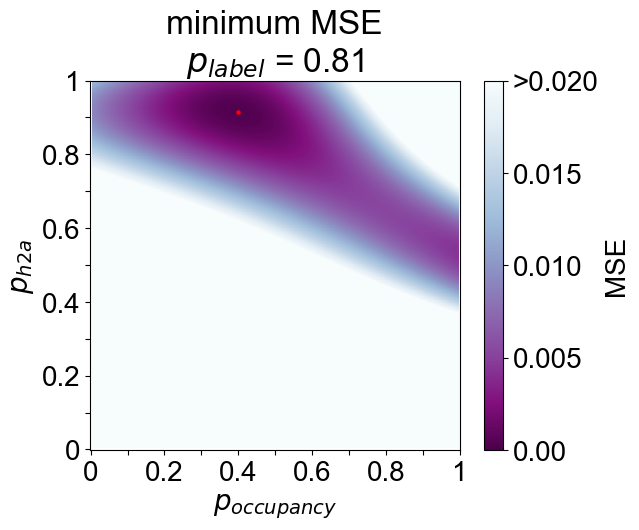

In [44]:
# Figure c) right
plt.figure()
plt.imshow(p_map, origin='lower', cmap='BuPu_r', vmin=0, vmax=0.02)
cbar = plt.colorbar(label='MSE', ticks=[0., 0.005, 0.01, 0.015, 0.02])
cbar.ax.set_yticklabels(['0.00', '0.005', '0.010', '0.015', '>0.020'])
plt.scatter([y_min], [x_min], c='r', s=5)
plt.xlabel('$p_{occupancy}$')#'$x_{my text}$'  p_occupancy
plt.ylabel('$p_{h2a}$')
plt.title('minimum MSE\n$p_{label}$ = %.2f' % p_label)
plt.yticks(np.arange(0, n_pixels+1, n_pixels/10), ('0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8',' ', '1' ))
plt.xticks(np.arange(0, n_pixels+1, n_pixels/10), ('0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8',' ', '1' ))
plt.show()

## Figure 1.5

In [49]:
# Directory for figures data
data_dir = r'figure_data/Suplementary Figures/Figure 1.5'

### b)

In [67]:
# Force / Lc table get table for plotting heatmap
file_path = os.path.join(data_dir, r'b', r'Lc_increment_analysis.csv')

df = pd.read_csv(file_path, float_precision='round_trip')

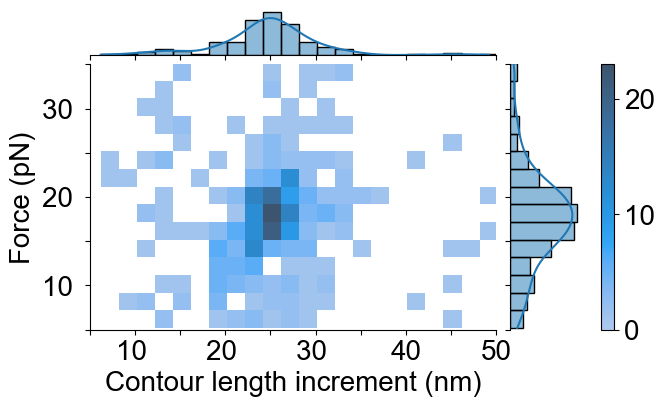

In [68]:
font = {'family':'arial', 'size'   : 20}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
bin_width = 2

grid = sns.jointplot(data=df,
                     x='delta_Lc[nm]', y='breaking_force[pN]', kind="hist", binwidth=bin_width, palette='tab10',
                  ratio=5, xlim=[5, 50], ylim=[5, 35], cbar=True,
                     marginal_kws=dict(binwidth=bin_width, kde=True))

plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)

# get the current positions of the joint ax and the ax for the marginal x
grid.fig.set_figwidth(7)
grid.fig.set_figheight(4)

plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)

# get the current positions of the joint ax and the ax for the marginal x
pos_joint_ax = grid.ax_joint.get_position()
pos_marg_x_ax = grid.ax_marg_x.get_position()

# reposition the joint ax so it has the same width as the marginal x ax
grid.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# reposition the colorbar using new x positions and y positions of the joint ax
grid.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])

# JointGrid has a convenience function
grid.set_axis_labels('Contour length increment (nm)', 'Force (pN)')


grid.ax_joint.set_xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
grid.ax_joint.set_xticklabels((' ', '10 ',' ','20 ',' ','30 ',' ', '40', '', '50' ))
grid.ax_joint.set_yticks([5, 10, 15, 20, 25, 30, 35])
grid.ax_joint.set_yticklabels((' ', '10 ',' ','20 ',' ','30 ',' ' ))
plt.show()

### c)

In [69]:
file_path = os.path.join(data_dir, r'c/n_jumps.csv')
df_fd_summary = pd.read_csv(file_path, float_precision='round_trip')
bins = np.arange(6) - 0.5
(Amnt, bins) = np.histogram(df_fd_summary['n_force_big'], bins=bins, 
                            weights=np.ones_like(df_fd_summary['n_force_big']) / len(df_fd_summary['n_force_big']))

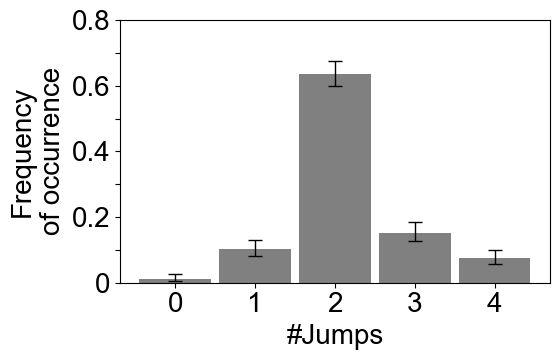

In [71]:
# Loc histogram for blue experiment_filtered_all00
font = {'family':'arial', 'size'   : 20}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
data = dict()
data['freqs'] = Amnt [0:5]
data['x'] = [0, 1, 2, 3, 4]
data['n_traces'] = len(df_fd_summary['n_force_big'])

# Plot histogram.
plt.xlabel('#Jumps')
plt.ylabel('Frequency\nof occurrence')
ax.bar(data['x'], data['freqs'], align='center', width=0.9, color='gray')
ax.xaxis.set_major_locator(plt.FixedLocator(data['x']))
plt.ylim((0, 0.8))
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], ('0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8'))
n_obs = data['n_traces']
errs = []
for b, c in zip(data['x'], data['freqs']):
        if c == 0:
            err = [0, 0]
        else:
            err = list(statsmodels.stats.proportion.proportion_confint(c * n_obs, n_obs,
                                                                       alpha=0.3173, method='wilson'))
            err[0] = c - err[0]
            err[1] = err[1] - c
        errs.append(err)
errs = np.array(errs).swapaxes(0, 1)
plt.errorbar(data['x'], data['freqs'], errs, fmt=' ', color='k', capsize=5, elinewidth=1, markeredgewidth=1)  
fig.tight_layout()
plt.show()